In [1]:
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2

In [2]:
class VOCDataset(Dataset):
    def __init__(self, data_dir, image_set="train", img_size=256):
        self.data_dir = data_dir
        self.transform = None
        self.image_dir = f"{self.data_dir}/JPEGImages"
        self.mask_dir = f"{self.data_dir}/SegmentationClass"

        with open(f"{self.data_dir}/ImageSets/Segmentation/{image_set}.txt", "r") as file:
            self.file_names = file.read().splitlines()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image_file = f"{self.image_dir}/{self.file_names[idx]}.jpg"
        mask_file = f"{self.mask_dir}/{self.file_names[idx]}.png"

        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        # 여기서 mask 값이 범위를 초과하는 경우 처리
        # mask[mask > 20] = 0  # 예시: 범위를 초과하는 값은 배경으로 처리

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        return {"pixel_values": image, "labels": mask}


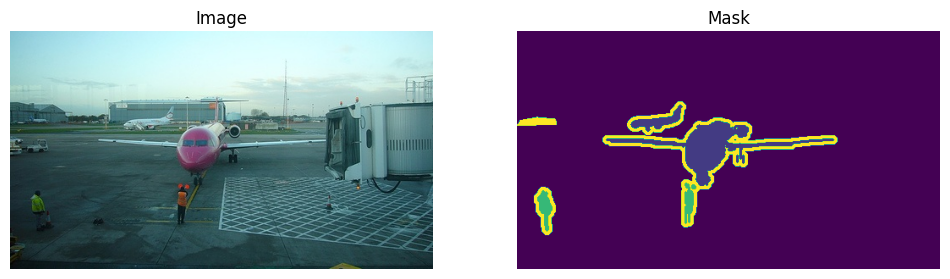

In [3]:
dataset = VOCDataset("/home/pervinco/Datasets/PASCAL_VOC/VOCDevkit/VOC2012")

sample = dataset[0]
image, mask = sample["pixel_values"], sample["labels"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="viridis")
ax[1].set_title("Mask")
ax[1].axis("off")

plt.show()

In [4]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

In [5]:
def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    plt.imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()

In [8]:
image = Image.open("/home/pervinco/Datasets/PASCAL_VOC/VOCDevkit/VOC2012/JPEGImages/2007_000129.jpg")
target = np.array(Image.open('/home/pervinco/Datasets/PASCAL_VOC/VOCDevkit/VOC2012/SegmentationClass/2007_000129.png'))[:, :, np.newaxis]
cmap = color_map()[:, np.newaxis, :]
new_im = np.dot(target == 0, cmap[0])
for i in range(1, cmap.shape[0]):
    new_im += np.dot(target == i, cmap[i])
new_im = Image.fromarray(new_im.astype(np.uint8))
blend_image = Image.blend(image, new_im, alpha=0.8)
blend_image.save('tmp.jpg')